In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Configurar estilo básico
sns.set()
plt.rcParams['figure.figsize'] = (10, 6)

print("Librerías cargadas exitosamente")
print("Iniciando análisis temporal de Ecobici...")


In [ ]:
# Cargar datos directamente desde CSV
print("Cargando datos desde archivo CSV...")
try:
    ecobici_data = pd.read_csv('2025-04.csv')
    print(f"Datos cargados exitosamente: {ecobici_data.shape[0]:,} registros")
    print(f"Columnas disponibles: {len(ecobici_data.columns)}")
    
    print("\nPrimeras 3 filas del dataset:")
    print(ecobici_data.head(3))
    
except FileNotFoundError:
    print("Error: Archivo 2025-04.csv no encontrado")
    ecobici_data = pd.DataFrame()
except Exception as e:
    print(f"Error al cargar datos: {e}")
    ecobici_data = pd.DataFrame()


In [ ]:
# Procesamiento temporal de datos
if not ecobici_data.empty:
    # Crear timestamps completos combinando fecha y hora
    ecobici_data['inicio_viaje'] = pd.to_datetime(
        ecobici_data['Fecha_Retiro'] + ' ' + ecobici_data['Hora_Retiro'], 
        format='%d/%m/%Y %H:%M:%S'
    )
    ecobici_data['fin_viaje'] = pd.to_datetime(
        ecobici_data['Fecha_Arribo'] + ' ' + ecobici_data['Hora_Arribo'], 
        format='%d/%m/%Y %H:%M:%S'
    )
    
    # Calcular duración en minutos
    ecobici_data['tiempo_viaje'] = (ecobici_data['fin_viaje'] - ecobici_data['inicio_viaje']).dt.total_seconds() / 60
    
    # Extraer información temporal
    ecobici_data['hora_inicio'] = ecobici_data['inicio_viaje'].dt.hour
    ecobici_data['dia_semana'] = ecobici_data['inicio_viaje'].dt.day_name()
    ecobici_data['es_fin_semana'] = ecobici_data['inicio_viaje'].dt.weekday >= 5
    
    print("Variables temporales creadas:")
    print(f"  - tiempo_viaje: {ecobici_data['tiempo_viaje'].describe()}")
    print(f"  - Rango horario: {ecobici_data['hora_inicio'].min()}h - {ecobici_data['hora_inicio'].max()}h")
    print(f"  - Días de la semana: {ecobici_data['dia_semana'].unique()}")
    
else:
    print("No hay datos para procesar")


In [ ]:
# Análisis de patrones horarios
if not ecobici_data.empty:
    # Filtrar datos válidos (duración entre 1 y 120 minutos)
    datos_limpios = ecobici_data[(ecobici_data['tiempo_viaje'] >= 1) & 
                                (ecobici_data['tiempo_viaje'] <= 120)].copy()
    
    print(f"Datos filtrados: {len(datos_limpios):,} viajes válidos")
    
    # Análisis por hora del día
    viajes_por_hora = datos_limpios.groupby('hora_inicio').agg({
        'tiempo_viaje': ['count', 'mean']
    }).round(2)
    
    viajes_por_hora.columns = ['total_viajes', 'duracion_promedio']
    
    print("\nPATRONES HORARIOS:")
    print(f"Hora con más viajes: {viajes_por_hora['total_viajes'].idxmax()}:00h")
    print(f"Duración promedio general: {datos_limpios['tiempo_viaje'].mean():.1f} minutos")
    
    # Visualización básica con Seaborn
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Gráfico 1: Viajes por hora
    sns.barplot(x=viajes_por_hora.index, y=viajes_por_hora['total_viajes'], ax=axes[0,0])
    axes[0,0].set_title('Viajes por Hora del Día')
    axes[0,0].set_xlabel('Hora')
    axes[0,0].set_ylabel('Número de Viajes')
    
    # Gráfico 2: Duración promedio por hora
    sns.lineplot(x=viajes_por_hora.index, y=viajes_por_hora['duracion_promedio'], 
                marker='o', ax=axes[0,1])
    axes[0,1].set_title('Duración Promedio por Hora')
    axes[0,1].set_xlabel('Hora')
    axes[0,1].set_ylabel('Minutos')
    
    # Gráfico 3: Distribución por género
    sns.countplot(data=datos_limpios, x='Genero_Usuario', ax=axes[1,0])
    axes[1,0].set_title('Distribución por Género')
    axes[1,0].set_xlabel('Género')
    axes[1,0].set_ylabel('Número de Viajes')
    
    # Gráfico 4: Distribución de duración
    sns.histplot(data=datos_limpios, x='tiempo_viaje', bins=30, ax=axes[1,1])
    axes[1,1].set_title('Distribución de Duración de Viajes')
    axes[1,1].set_xlabel('Duración (minutos)')
    axes[1,1].set_ylabel('Frecuencia')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No hay datos para el análisis horario")


In [ ]:
# Modelo predictivo simple
if not ecobici_data.empty and len(datos_limpios) > 0:
    print("MODELO PREDICTIVO TEMPORAL")
    
    # Preparar variables para predicción
    modelo_data = datos_limpios[['hora_inicio', 'Edad_Usuario', 'tiempo_viaje']].copy()
    modelo_data = modelo_data.dropna()
    
    # Variables independientes y dependiente
    X_temporal = modelo_data[['hora_inicio', 'Edad_Usuario']]
    y_temporal = modelo_data['tiempo_viaje']
    
    # Crear y entrenar modelo
    modelo_temporal = LinearRegression()
    modelo_temporal.fit(X_temporal, y_temporal)
    
    # Hacer predicciones
    predicciones_tiempo = modelo_temporal.predict(X_temporal)
    r2_temporal = r2_score(y_temporal, predicciones_tiempo)
    
    print(f"Resultados del modelo:")
    print(f"   R²: {r2_temporal:.4f}")
    print(f"   El modelo explica {r2_temporal*100:.2f}% de la variabilidad")
    
    print(f"\nCoeficientes del modelo:")
    coeficientes = ['Hora del día', 'Edad del usuario']
    for coef, nombre in zip(modelo_temporal.coef_, coeficientes):
        print(f"   {nombre}: {coef:.4f}")
    print(f"   Intercepto: {modelo_temporal.intercept_:.4f}")
    
    # Visualización del modelo
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Gráfico 1: Real vs Predicho
    muestra = np.random.choice(len(y_temporal), 1000, replace=False)
    sns.scatterplot(x=y_temporal.iloc[muestra], y=predicciones_tiempo[muestra], 
                    alpha=0.5, ax=axes[0])
    axes[0].plot([y_temporal.min(), y_temporal.max()], [y_temporal.min(), y_temporal.max()], 'r--')
    axes[0].set_xlabel('Tiempo Real (minutos)')
    axes[0].set_ylabel('Tiempo Predicho (minutos)')
    axes[0].set_title(f'Modelo (R² = {r2_temporal:.3f})')
    
    # Gráfico 2: Duración por género
    sns.boxplot(data=datos_limpios, x='Genero_Usuario', y='tiempo_viaje', ax=axes[1])
    axes[1].set_title('Duración por Género')
    axes[1].set_xlabel('Género')
    axes[1].set_ylabel('Tiempo de Viaje (min)')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No hay suficientes datos para el modelo predictivo")


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Configurar estilo básico
sns.set()
plt.rcParams['figure.figsize'] = (10, 6)

print("Librerías cargadas exitosamente")
print("Iniciando análisis temporal de Ecobici...")


Librerías cargadas exitosamente
Iniciando análisis temporal de Ecobici...


In [2]:
# Cargar datos directamente desde CSV
print("Cargando datos desde archivo CSV...")
try:
    # Leer directamente el archivo CSV (sin necesidad de extraer ZIP)
    ecobici_data = pd.read_csv('2025-04.csv')
    print(f"Datos cargados exitosamente: {ecobici_data.shape[0]:,} registros")
    print(f"Columnas disponibles: {len(ecobici_data.columns)}")
    
    # Mostrar información básica
    print("\nPrimeras 3 filas del dataset:")
    print(ecobici_data.head(3))
    
except FileNotFoundError:
    print("Error: Archivo 2025-04.csv no encontrado")
    ecobici_data = pd.DataFrame()
except Exception as e:
    print(f"Error al cargar datos: {e}")
    ecobici_data = pd.DataFrame()


Cargando datos desde archivo CSV...
Datos cargados exitosamente: 1,727,987 registros
Columnas disponibles: 9

Primeras 3 filas del dataset:
  Genero_Usuario  Edad_Usuario     Bici Ciclo_Estacion_Retiro Fecha_Retiro  \
0              F          22.0  2586485               107-108   31/03/2025   
1              M          50.0  8152522                   384   31/03/2025   
2              M          24.0  4219945                   021   31/03/2025   

  Hora_Retiro Ciclo_EstacionArribo Fecha_Arribo Hora_Arribo  
0    23:34:46                  181   01/04/2025    00:00:12  
1    23:43:51                  387   01/04/2025    00:00:16  
2    23:42:36                  548   01/04/2025    00:00:23  


In [3]:
# Procesamiento temporal de datos
if not ecobici_data.empty:
    # Crear timestamps completos combinando fecha y hora
    ecobici_data['inicio_viaje'] = pd.to_datetime(
        ecobici_data['Fecha_Retiro'] + ' ' + ecobici_data['Hora_Retiro'], 
        format='%d/%m/%Y %H:%M:%S'
    )
    ecobici_data['fin_viaje'] = pd.to_datetime(
        ecobici_data['Fecha_Arribo'] + ' ' + ecobici_data['Hora_Arribo'], 
        format='%d/%m/%Y %H:%M:%S'
    )
    
    # Calcular duración en minutos
    ecobici_data['tiempo_viaje'] = (ecobici_data['fin_viaje'] - ecobici_data['inicio_viaje']).dt.total_seconds() / 60
    
    # Extraer información temporal
    ecobici_data['hora_inicio'] = ecobici_data['inicio_viaje'].dt.hour
    ecobici_data['dia_semana'] = ecobici_data['inicio_viaje'].dt.day_name()
    ecobici_data['es_fin_semana'] = ecobici_data['inicio_viaje'].dt.weekday >= 5
    
    print("Variables temporales creadas:")
    print(f"  - tiempo_viaje: {ecobici_data['tiempo_viaje'].describe()}")
    print(f"  - Rango horario: {ecobici_data['hora_inicio'].min()}h - {ecobici_data['hora_inicio'].max()}h")
    print(f"  - Días de la semana: {ecobici_data['dia_semana'].unique()}")
    
else:
    print("No hay datos para procesar")


Variables temporales creadas:
  - tiempo_viaje: count    1.727987e+06
mean     1.751970e+01
std      1.020443e+03
min      4.500000e-01
25%      7.250000e+00
50%      1.213333e+01
75%      2.023333e+01
max      1.248537e+06
Name: tiempo_viaje, dtype: float64
  - Rango horario: 0h - 23h
  - Días de la semana: ['Monday' 'Tuesday' 'Saturday' 'Sunday' 'Wednesday' 'Thursday' 'Friday']


Datos filtrados: 1,726,400 viajes válidos

PATRONES HORARIOS:
Hora con más viajes: 18:00h
Duración promedio general: 15.2 minutos


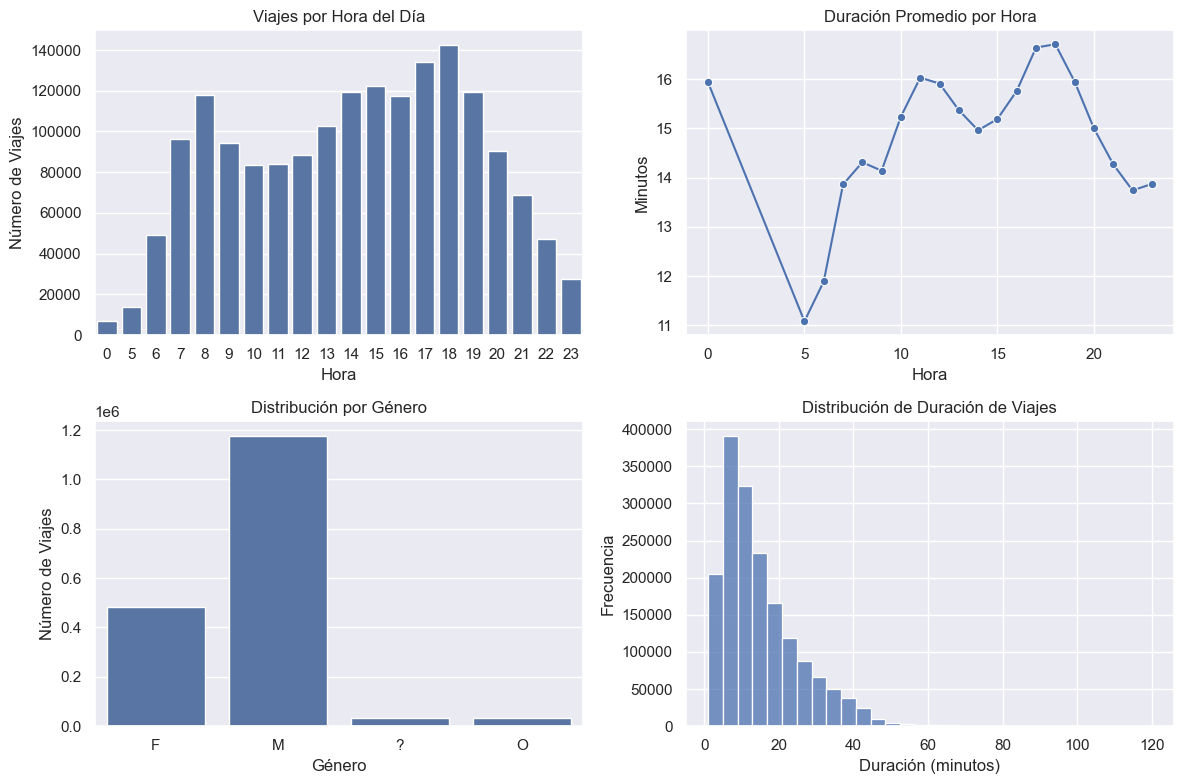

In [4]:
# Análisis de patrones horarios
if not ecobici_data.empty:
    # Filtrar datos válidos (duración entre 1 y 120 minutos)
    datos_limpios = ecobici_data[(ecobici_data['tiempo_viaje'] >= 1) & 
                                (ecobici_data['tiempo_viaje'] <= 120)].copy()
    
    print(f"Datos filtrados: {len(datos_limpios):,} viajes válidos")
    
    # Análisis por hora del día
    viajes_por_hora = datos_limpios.groupby('hora_inicio').agg({
        'tiempo_viaje': ['count', 'mean']
    }).round(2)
    
    viajes_por_hora.columns = ['total_viajes', 'duracion_promedio']
    
    print("\nPATRONES HORARIOS:")
    print(f"Hora con más viajes: {viajes_por_hora['total_viajes'].idxmax()}:00h")
    print(f"Duración promedio general: {datos_limpios['tiempo_viaje'].mean():.1f} minutos")
    
    # Visualización básica con Seaborn
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Gráfico 1: Viajes por hora
    sns.barplot(x=viajes_por_hora.index, y=viajes_por_hora['total_viajes'], ax=axes[0,0])
    axes[0,0].set_title('Viajes por Hora del Día')
    axes[0,0].set_xlabel('Hora')
    axes[0,0].set_ylabel('Número de Viajes')
    
    # Gráfico 2: Duración promedio por hora
    sns.lineplot(x=viajes_por_hora.index, y=viajes_por_hora['duracion_promedio'], 
                marker='o', ax=axes[0,1])
    axes[0,1].set_title('Duración Promedio por Hora')
    axes[0,1].set_xlabel('Hora')
    axes[0,1].set_ylabel('Minutos')
    
    # Gráfico 3: Distribución por género
    sns.countplot(data=datos_limpios, x='Genero_Usuario', ax=axes[1,0])
    axes[1,0].set_title('Distribución por Género')
    axes[1,0].set_xlabel('Género')
    axes[1,0].set_ylabel('Número de Viajes')
    
    # Gráfico 4: Distribución de duración
    sns.histplot(data=datos_limpios, x='tiempo_viaje', bins=30, ax=axes[1,1])
    axes[1,1].set_title('Distribución de Duración de Viajes')
    axes[1,1].set_xlabel('Duración (minutos)')
    axes[1,1].set_ylabel('Frecuencia')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No hay datos para el análisis horario")


MODELO PREDICTIVO TEMPORAL
Resultados del modelo:
   R²: 0.0021
   El modelo explica 0.21% de la variabilidad

Coeficientes del modelo:
   Hora del día: 0.1039
   Edad del usuario: -0.0051
   Intercepto: 13.8747


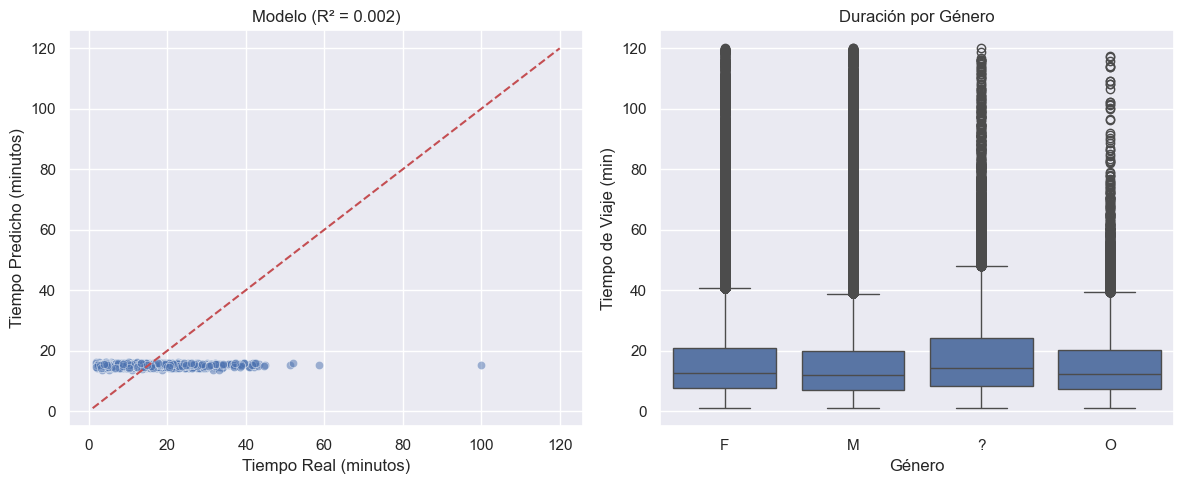

In [5]:
# Modelo predictivo simple
if not ecobici_data.empty and len(datos_limpios) > 0:
    print("MODELO PREDICTIVO TEMPORAL")
    
    # Preparar variables para predicción
    modelo_data = datos_limpios[['hora_inicio', 'Edad_Usuario', 'tiempo_viaje']].copy()
    modelo_data = modelo_data.dropna()
    
    # Variables independientes y dependiente
    X_temporal = modelo_data[['hora_inicio', 'Edad_Usuario']]
    y_temporal = modelo_data['tiempo_viaje']
    
    # Crear y entrenar modelo
    modelo_temporal = LinearRegression()
    modelo_temporal.fit(X_temporal, y_temporal)
    
    # Hacer predicciones
    predicciones_tiempo = modelo_temporal.predict(X_temporal)
    r2_temporal = r2_score(y_temporal, predicciones_tiempo)
    
    print(f"Resultados del modelo:")
    print(f"   R²: {r2_temporal:.4f}")
    print(f"   El modelo explica {r2_temporal*100:.2f}% de la variabilidad")
    
    print(f"\nCoeficientes del modelo:")
    coeficientes = ['Hora del día', 'Edad del usuario']
    for coef, nombre in zip(modelo_temporal.coef_, coeficientes):
        print(f"   {nombre}: {coef:.4f}")
    print(f"   Intercepto: {modelo_temporal.intercept_:.4f}")
    
    # Visualización del modelo
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Gráfico 1: Real vs Predicho
    muestra = np.random.choice(len(y_temporal), 1000, replace=False)
    sns.scatterplot(x=y_temporal.iloc[muestra], y=predicciones_tiempo[muestra], 
                    alpha=0.5, ax=axes[0])
    axes[0].plot([y_temporal.min(), y_temporal.max()], [y_temporal.min(), y_temporal.max()], 'r--')
    axes[0].set_xlabel('Tiempo Real (minutos)')
    axes[0].set_ylabel('Tiempo Predicho (minutos)')
    axes[0].set_title(f'Modelo (R² = {r2_temporal:.3f})')
    
    # Gráfico 2: Duración por género
    sns.boxplot(data=datos_limpios, x='Genero_Usuario', y='tiempo_viaje', ax=axes[1])
    axes[1].set_title('Duración por Género')
    axes[1].set_xlabel('Género')
    axes[1].set_ylabel('Tiempo de Viaje (min)')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No hay suficientes datos para el modelo predictivo")


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Configurar estilo de gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Librerías cargadas exitosamente")
print("Iniciando análisis temporal de Ecobici...")


Librerías cargadas exitosamente
Iniciando análisis temporal de Ecobici...


In [15]:
# Cargar datos directamente desde CSV
print("Cargando datos desde archivo CSV...")
try:
    # Leer directamente el archivo CSV (sin necesidad de extraer ZIP)
    ecobici_data = pd.read_csv('2025-04.csv')
    print(f"✓ Datos cargados exitosamente: {ecobici_data.shape[0]:,} registros")
    print(f"✓ Columnas disponibles: {len(ecobici_data.columns)}")
    
    # Mostrar información básica
    print("\nPrimeras 3 filas del dataset:")
    print(ecobici_data.head(3))
    
except FileNotFoundError:
    print(" Error: Archivo 2025-04.csv no encontrado")
    ecobici_data = pd.DataFrame()
except Exception as e:
    print(f" Error al cargar datos: {e}")
    ecobici_data = pd.DataFrame()


Cargando datos desde archivo CSV...


✓ Datos cargados exitosamente: 1,727,987 registros
✓ Columnas disponibles: 9

Primeras 3 filas del dataset:
  Genero_Usuario  Edad_Usuario     Bici Ciclo_Estacion_Retiro Fecha_Retiro  \
0              F          22.0  2586485               107-108   31/03/2025   
1              M          50.0  8152522                   384   31/03/2025   
2              M          24.0  4219945                   021   31/03/2025   

  Hora_Retiro Ciclo_EstacionArribo Fecha_Arribo Hora_Arribo  
0    23:34:46                  181   01/04/2025    00:00:12  
1    23:43:51                  387   01/04/2025    00:00:16  
2    23:42:36                  548   01/04/2025    00:00:23  


In [14]:
# Procesamiento temporal de datos
if not ecobici_data.empty:
    # Crear timestamps completos combinando fecha y hora
    ecobici_data['inicio_viaje'] = pd.to_datetime(
        ecobici_data['Fecha_Retiro'] + ' ' + ecobici_data['Hora_Retiro'], 
        format='%d/%m/%Y %H:%M:%S'
    )
    ecobici_data['fin_viaje'] = pd.to_datetime(
        ecobici_data['Fecha_Arribo'] + ' ' + ecobici_data['Hora_Arribo'], 
        format='%d/%m/%Y %H:%M:%S'
    )
    
    # Calcular duración en minutos
    ecobici_data['tiempo_viaje'] = (ecobici_data['fin_viaje'] - ecobici_data['inicio_viaje']).dt.total_seconds() / 60
    
    # Extraer información temporal
    ecobici_data['hora_inicio'] = ecobici_data['inicio_viaje'].dt.hour
    ecobici_data['dia_semana'] = ecobici_data['inicio_viaje'].dt.day_name()
    ecobici_data['es_fin_semana'] = ecobici_data['inicio_viaje'].dt.weekday >= 5
    
    print("✓ Variables temporales creadas:")
    print(f"  - tiempo_viaje: {ecobici_data['tiempo_viaje'].describe()}")
    print(f"  - Rango horario: {ecobici_data['hora_inicio'].min()}h - {ecobici_data['hora_inicio'].max()}h")
    print(f"  - Días de la semana: {ecobici_data['dia_semana'].unique()}")
    
else:
    print(" No hay datos para procesar")


✓ Variables temporales creadas:
  - tiempo_viaje: count    1.727987e+06
mean     1.751970e+01
std      1.020443e+03
min      4.500000e-01
25%      7.250000e+00
50%      1.213333e+01
75%      2.023333e+01
max      1.248537e+06
Name: tiempo_viaje, dtype: float64
  - Rango horario: 0h - 23h
  - Días de la semana: ['Monday' 'Tuesday' 'Saturday' 'Sunday' 'Wednesday' 'Thursday' 'Friday']


Datos filtrados: 1,726,400 viajes válidos

 PATRONES HORARIOS:
 Hora pico matutina: 8:00h (117,993 viajes)
 Hora pico vespertina: 18:00h (142,533 viajes)


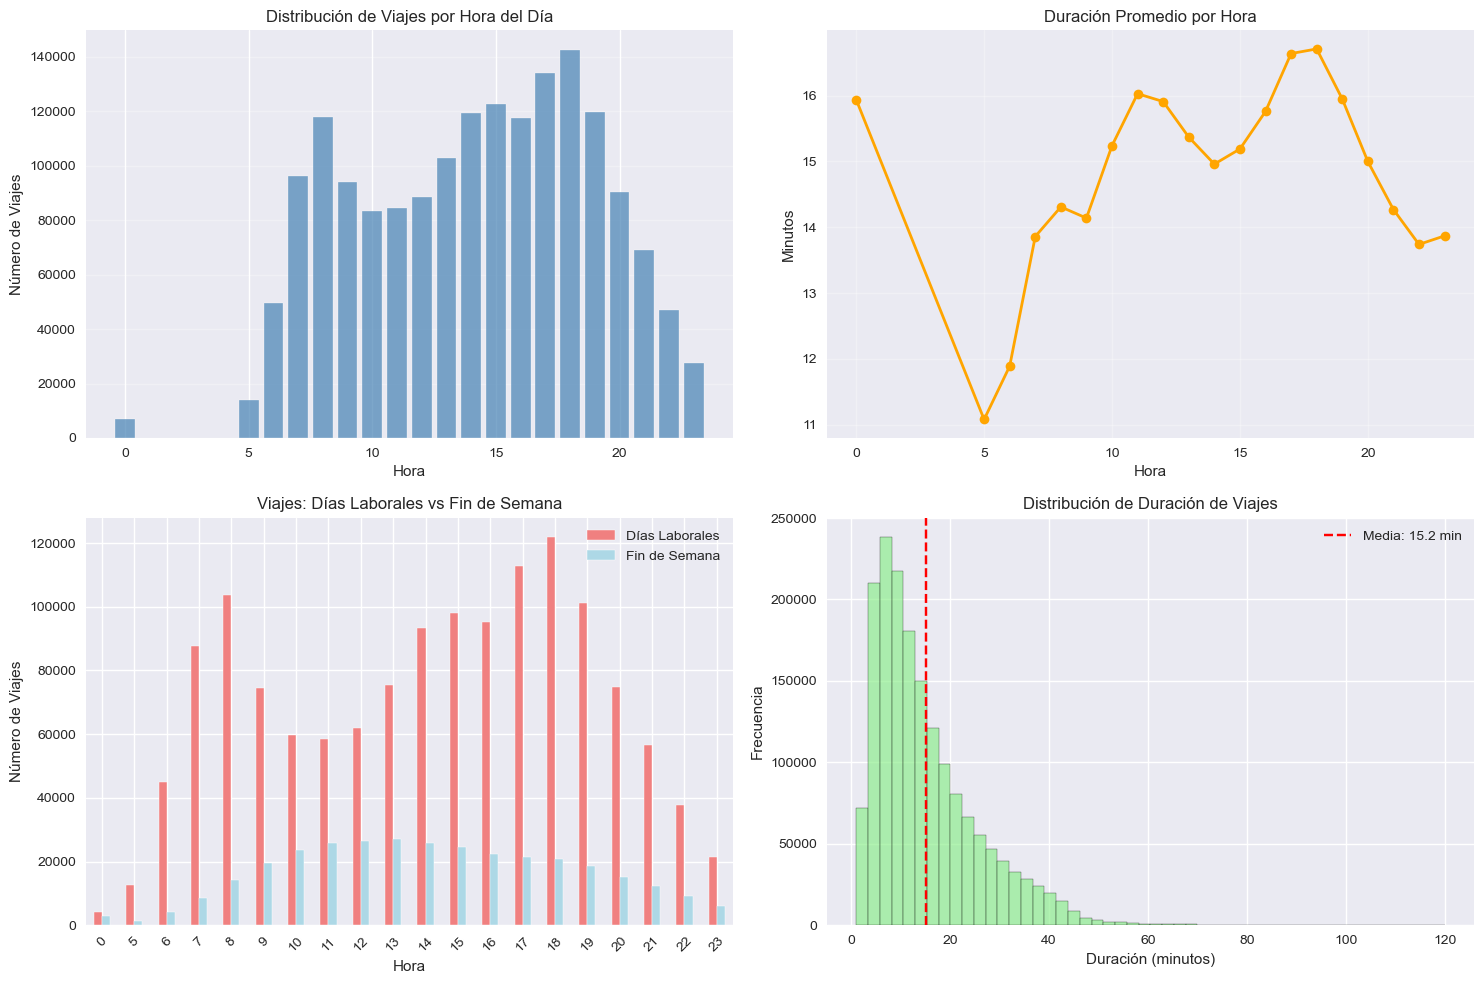

In [13]:
# Análisis de patrones horarios
if not ecobici_data.empty:
    # Filtrar datos válidos (duración entre 1 y 120 minutos)
    datos_limpios = ecobici_data[(ecobici_data['tiempo_viaje'] >= 1) & 
                                (ecobici_data['tiempo_viaje'] <= 120)].copy()
    
    print(f"Datos filtrados: {len(datos_limpios):,} viajes válidos")
    
    # Análisis por hora del día
    viajes_por_hora = datos_limpios.groupby('hora_inicio').agg({
        'tiempo_viaje': ['count', 'mean'],
        'Edad_Usuario': 'mean'
    }).round(2)
    
    viajes_por_hora.columns = ['total_viajes', 'duracion_promedio', 'edad_promedio']
    
    # Identificar horas pico
    hora_pico_mañana = viajes_por_hora.loc[6:10, 'total_viajes'].idxmax()
    hora_pico_tarde = viajes_por_hora.loc[17:21, 'total_viajes'].idxmax()
    
    print(f"\n PATRONES HORARIOS:")
    print(f" Hora pico matutina: {hora_pico_mañana}:00h ({viajes_por_hora.loc[hora_pico_mañana, 'total_viajes']:,} viajes)")
    print(f" Hora pico vespertina: {hora_pico_tarde}:00h ({viajes_por_hora.loc[hora_pico_tarde, 'total_viajes']:,} viajes)")
    
    # Visualización de patrones horarios
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Gráfico 1: Viajes por hora
    axes[0,0].bar(viajes_por_hora.index, viajes_por_hora['total_viajes'], 
                  color='steelblue', alpha=0.7)
    axes[0,0].set_title('Distribución de Viajes por Hora del Día')
    axes[0,0].set_xlabel('Hora')
    axes[0,0].set_ylabel('Número de Viajes')
    axes[0,0].grid(axis='y', alpha=0.3)
    
    # Gráfico 2: Duración promedio por hora
    axes[0,1].plot(viajes_por_hora.index, viajes_por_hora['duracion_promedio'], 
                   marker='o', color='orange', linewidth=2)
    axes[0,1].set_title('Duración Promedio por Hora')
    axes[0,1].set_xlabel('Hora')
    axes[0,1].set_ylabel('Minutos')
    axes[0,1].grid(alpha=0.3)
    
    # Gráfico 3: Comparación fin de semana vs días laborales
    comparacion_semana = datos_limpios.groupby(['hora_inicio', 'es_fin_semana'])['tiempo_viaje'].count().unstack()
    comparacion_semana.plot(kind='bar', ax=axes[1,0], color=['lightcoral', 'lightblue'])
    axes[1,0].set_title('Viajes: Días Laborales vs Fin de Semana')
    axes[1,0].set_xlabel('Hora')
    axes[1,0].set_ylabel('Número de Viajes')
    axes[1,0].legend(['Días Laborales', 'Fin de Semana'])
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Gráfico 4: Distribución de duración de viajes
    axes[1,1].hist(datos_limpios['tiempo_viaje'], bins=50, color='lightgreen', alpha=0.7, edgecolor='black')
    axes[1,1].set_title('Distribución de Duración de Viajes')
    axes[1,1].set_xlabel('Duración (minutos)')
    axes[1,1].set_ylabel('Frecuencia')
    axes[1,1].axvline(datos_limpios['tiempo_viaje'].mean(), color='red', 
                      linestyle='--', label=f'Media: {datos_limpios["tiempo_viaje"].mean():.1f} min')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
else:
    print(" No hay datos para el análisis horario")


 MODELO PREDICTIVO TEMPORAL
 Resultados del modelo:
   R² (coeficiente de determinación): 0.0091
   El modelo explica 0.91% de la variabilidad en el tiempo de viaje

 Coeficientes del modelo:
   Hora del día: 0.1049
   Es fin de semana: 2.3256
   Edad del usuario: -0.0033
   Intercepto: 13.3555

 Ejemplos de predicción:
   Hora 8:00, día laboral, 30 años → 14.1 minutos
   Hora 14:00, fin de semana, 25 años → 17.1 minutos
   Hora 18:00, día laboral, 35 años → 15.1 minutos


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


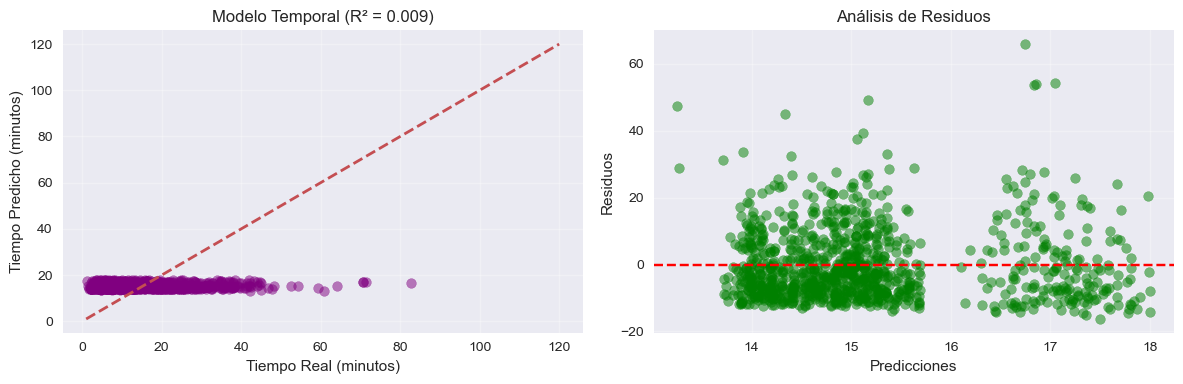

In [12]:
# Modelo predictivo temporal simple
if not ecobici_data.empty and len(datos_limpios) > 0:
    print(" MODELO PREDICTIVO TEMPORAL")
    
    # Preparar variables para predicción
    # Variable objetivo: tiempo de viaje
    # Variables predictoras: hora, si es fin de semana, edad
    
    modelo_data = datos_limpios[['hora_inicio', 'es_fin_semana', 'Edad_Usuario', 'tiempo_viaje']].copy()
    modelo_data = modelo_data.dropna()
    
    # Convertir booleano a numérico
    modelo_data['fin_semana_num'] = modelo_data['es_fin_semana'].astype(int)
    
    # Variables independientes y dependiente
    X_temporal = modelo_data[['hora_inicio', 'fin_semana_num', 'Edad_Usuario']]
    y_temporal = modelo_data['tiempo_viaje']
    
    # Crear y entrenar modelo
    modelo_temporal = LinearRegression()
    modelo_temporal.fit(X_temporal, y_temporal)
    
    # Hacer predicciones
    predicciones_tiempo = modelo_temporal.predict(X_temporal)
    r2_temporal = r2_score(y_temporal, predicciones_tiempo)
    
    print(f" Resultados del modelo:")
    print(f"   R² (coeficiente de determinación): {r2_temporal:.4f}")
    print(f"   El modelo explica {r2_temporal*100:.2f}% de la variabilidad en el tiempo de viaje")
    
    print(f"\n Coeficientes del modelo:")
    coeficientes = ['Hora del día', 'Es fin de semana', 'Edad del usuario']
    for coef, nombre in zip(modelo_temporal.coef_, coeficientes):
        print(f"   {nombre}: {coef:.4f}")
    print(f"   Intercepto: {modelo_temporal.intercept_:.4f}")
    
    # Predicciones ejemplo
    print(f"\n Ejemplos de predicción:")
    ejemplos = [
        [8, 0, 30],   # 8am, día laboral, 30 años
        [14, 1, 25],  # 2pm, fin de semana, 25 años  
        [18, 0, 35]   # 6pm, día laboral, 35 años
    ]
    
    for ejemplo in ejemplos:
        pred = modelo_temporal.predict([ejemplo])[0]
        tipo_dia = "fin de semana" if ejemplo[1] else "día laboral"
        print(f"   Hora {ejemplo[0]}:00, {tipo_dia}, {ejemplo[2]} años → {pred:.1f} minutos")
    
    # Visualización del modelo
    plt.figure(figsize=(12, 4))
    
    # Comparación real vs predicho
    plt.subplot(1, 2, 1)
    muestra = np.random.choice(len(y_temporal), 1000, replace=False)
    plt.scatter(y_temporal.iloc[muestra], predicciones_tiempo[muestra], alpha=0.5, color='purple')
    plt.plot([y_temporal.min(), y_temporal.max()], [y_temporal.min(), y_temporal.max()], 'r--', lw=2)
    plt.xlabel('Tiempo Real (minutos)')
    plt.ylabel('Tiempo Predicho (minutos)')
    plt.title(f'Modelo Temporal (R² = {r2_temporal:.3f})')
    plt.grid(alpha=0.3)
    
    # Residuos
    plt.subplot(1, 2, 2)
    residuos = y_temporal.iloc[muestra] - predicciones_tiempo[muestra]
    plt.scatter(predicciones_tiempo[muestra], residuos, alpha=0.5, color='green')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicciones')
    plt.ylabel('Residuos')
    plt.title('Análisis de Residuos')
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print(" No hay suficientes datos para el modelo predictivo")
